In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_stata("../data/gss2020panel_r1a.dta", convert_categoricals=False)

C:\Users\yuanx\AppData\Local\Temp\ipykernel_11856\1295668150.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata("../data/gss2020panel_r1a.dta", convert_categoricals=False)


In [5]:
# select 2028 data
df_2018 = df[df['samptype'] == 2018].copy()
# select variables
col_list = ['marital_1b', 'mntlhlth_1b', 'degree_1b', 'satfin_1b', 'neisafe_1b', 'relpersn_1b', 'race_1b']
df_2018_sub = df_2018[col_list].copy()
# drop rows that have any NA
df_2018_sub = df_2018_sub.dropna(how='any')
# only keep married (marital == 1) and never married (marital == 5)
df_2018_sub.loc[df_2018_sub['marital_1b'].isin([1,5])].shape
df_2018_sub.shape
# rename columns to remove suffix
col_dict = {x: x.split('_')[0] for x in list(df_2018_sub.columns)}
df_2018_sub.rename(columns=col_dict, inplace=True)
df_2018_sub['marital'] = df_2018_sub['marital'].apply(lambda x: 1 if x == 1 else 0)
# one-hot encoding race variable
df_2018_sub['race_is_white'] = df_2018_sub['race'].isin([1])
df_2018_sub['race_is_black'] = df_2018_sub['race'].isin([2])
df_2018_sub['race_is_other'] = df_2018_sub['race'].isin([3])
df_2018_sub.drop(columns=['race'], inplace=True)
df_2018_sub.to_csv(path_or_buf='data_2018_mntlhlth_marital_trim.csv', index=False)

In [6]:
df_2018_sub.shape

(1393, 9)

In [7]:
# train test split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X = df_2018_sub.drop(columns=['mntlhlth', 'marital'])
y = df_2018_sub['marital']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [8]:
# random search the hyperparameter space
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [9]:
rf = RandomForestClassifier(random_state=99)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': True}


In [47]:
import json
fname = 'random_search_best_param.json'
with open(fname, "w") as outfile: 
    json.dump(rf_random.best_params_, outfile)

with open(fname, 'r') as infile:
    param_dict = json.load(infile)

In [20]:
param_dict

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 70,
 'bootstrap': True}

In [36]:
param_grid = {
    
    'n_estimators': [param_dict['n_estimators'] - 200, param_dict['n_estimators'],param_dict['n_estimators'] + 200],
    'min_samples_split': [param_dict['min_samples_split'] - 2, param_dict['min_samples_split'], param_dict['min_samples_split'] + 2],
    'min_samples_leaf': [param_dict['min_samples_leaf'] - 2, param_dict['min_samples_leaf'],param_dict['min_samples_leaf'] + 2],
    'max_features': [param_dict['max_features']],
    'max_depth': [param_dict['max_depth'] - 20, param_dict['max_depth'], param_dict['max_depth'] + 20],
    'bootstrap': [param_dict['bootstrap']],
    
}

In [37]:
fname = '2018_hlthmntl_best_param.json'
with open(fname, "w") as outfile: 
    json.dump(rf_random.best_params_, outfile)

with open(fname, 'r') as infile:
    param_dict = json.load(infile)

{'n_estimators': [200, 400, 600],
 'min_samples_split': [8, 10, 12],
 'min_samples_leaf': [2, 4, 6],
 'max_features': ['log2'],
 'max_depth': [50, 70, 90],
 'bootstrap': [True]}

In [38]:
# grid search near the hyperparameters obtained through random search
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=99)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=400; total

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=99),
             param_grid={'bootstrap': [True], 'max_depth': [50, 70, 90],
                         'max_features': ['log2'],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [200, 400, 600]},
             verbose=2)

In [41]:
# assemble all results for output

PS_model_save = grid_search.best_params_

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
PS_model_save['test_score'] = round(best_rf.score(X_test, y_test), 4)
PS_model_save['train_score'] = round(best_rf.score(X_train, y_train),4)

fname = '2018_marital_trim_PS.json'
with open(fname, "w") as outfile: 
    json.dump(PS_model_save, outfile)

In [43]:
print('Test set score:', round(best_rf.score(X_test, y_test), 4))
print('Train set score:', round(best_rf.score(X_train, y_train), 4))

Test set score: 0.5986
Train set score: 0.6903


In [44]:
df_2018_sub['propensity'] = best_rf.predict_proba(df_2018_sub.drop(columns=['mntlhlth', 'marital']))[:,1]

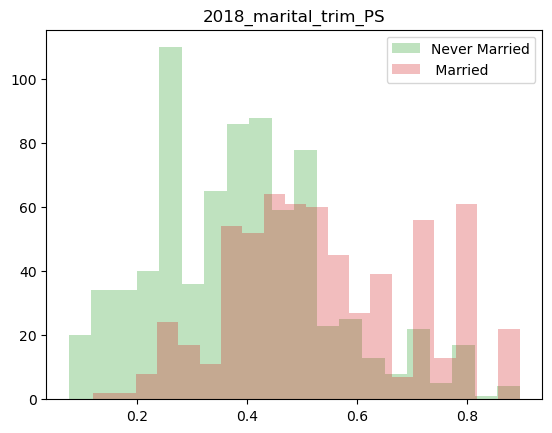

In [46]:
# plt.hist(df_2018_sub["propensity"], bins=20, alpha=0.3, label="All")
plt.hist(df_2018_sub.query("marital==0")["propensity"], bins=20, alpha=0.3, color="C2", label='Never Married')
plt.hist(df_2018_sub.query("marital==1")["propensity"], bins=20, alpha=0.3, color="C3", label=' Married')
plt.title('2018_marital_trim_PS')
plt.legend()